In [1]:
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords 
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

Using TensorFlow backend.


LOAD AND PROCESS DATA

In [2]:
df = pd.read_csv('fake_or_real_news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
df.info

<bound method DataFrame.info of       Unnamed: 0                                              title  \
0           8476                       You Can Smell Hillary’s Fear   
1          10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2           3608        Kerry to go to Paris in gesture of sympathy   
3          10142  Bernie supporters on Twitter erupt in anger ag...   
4            875   The Battle of New York: Why This Primary Matters   
...          ...                                                ...   
6330        4490  State Department says it can't find emails fro...   
6331        8062  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332        8622  Anti-Trump Protesters Are Tools of the Oligarc...   
6333        4021  In Ethiopia, Obama seeks progress on peace, se...   
6334        4330  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                   text label  
0     Daniel Greenfield, a Shillman Journalism Fell

In [4]:
x = df['title'] + " " + df['text']
y = pd.get_dummies(df['label'])
y = np.array(y)

DEFINING PARAMETERS

In [6]:
MAX_NB_WORDS = 100000 # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding
VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 100 # embedding dimensions for word vectors
GLOVE_DIR = "glove.6B."+str(EMBEDDING_DIM)+"d.txt"

DATA CLEANING

In [42]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace(r'http[\w:/\.]+','') # removing urls
    text = str(text).replace(r'[^\.\w\s]','') #remove everything but characters and punctuation text = str(text).replace(r’\.\.+’,’.’) #replace multiple periods with a single one text = str(text).replace(r’\.’,’ . ‘) #replace periods with a single one text = str(text).replace(r’\s\s+’,’ ‘) #replace multiple white space with a single one text = str(text).replace(“\n”, “”) #removing line breaks
    text = re.sub(r'[^\w\s]','',text).lower() #lower texts if remove_stopwords:
    text = text.split(' ')
    
    for word in text:
        if word not in stopwords.words('english'):
            output = output + " " + str(word)
        else:
            output = text
            
    return str(output.strip())[1:-3].replace(" ", " ")

NLTK CLEANING

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jeanine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
texts = [] 
for line in tqdm_notebook(x, total=df.shape[0]): 
    texts.append(clean_text(line))

TypeError: can only concatenate list (not "str") to list

In [46]:
print('Sample data:', x[0], y[0])

Sample data: You Can Smell Hillary’s Fear Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. 
In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. 
The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. 
But that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. 
The FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. 
The FBI’s leade

In [50]:
texts = x

In [51]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 99764


In [54]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (6335, 1000)
Shape of label tensor: (6335, 2)


In [55]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [59]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('Validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [2544 2524]
Validation:  [620 647]


In [61]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 4919 11843   311  1016   354    10  4753  5944   756  1356   166    12
    24  9511    95   311   766  8623  3961     5  1661   299    10     5
  4029  5944     4  1201   163   660   275  2468   189   697   697   189
     1   756  4555  2016    10   564   639     7   342   480    51  1525
    72   701     2 17611     5  1661    25     1  1168  4927  4567   337
  5944   164    37    71    31   315   390   115  5314 50374  2719   101
   148  1321  8382     6     1   337     3 33483     1  2699    51  1525
    44   155   118     1  2719    54  2771    72  1298   210  3304 16498
   613   104  1064     7    83   667     6     1  1433   347     3  1407
    21    26  4555  2016  1063   365   256 19507   440 22010     5   198
   413   256 34913 80590    26     5  3201  2256   225  2951 14638     3
  4994    15   285   710     1  5944    14   464     7     1  2699    52
   947     2   528  1331    47     6     1 80591  5800   329    37  3304
  1821     1  2719 15000  31

GLOVE

In [66]:
embeddings_index = {}

f = open(GLOVE_DIR, encoding='utf8')
print('Loading Glove from:', GLOVE_DIR,'…', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')

f.close()
print("Done.\n Proceeding with Embedding Matrix…", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
print("Completed!")

Loading Glove from: glove.6B.100d.txt …Done.
 Proceeding with Embedding Matrix…Completed!


MODEL

In [68]:
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length = MAX_SEQUENCE_LENGTH, trainable=False, name = 'embeddings'))
model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(2, activation="sigmoid"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [69]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


TRAIN MODEL

In [93]:
history = model.fit(x_train, y_train, epochs = 10, batch_size=128, validation_data=(x_val, y_val))

Train on 5068 samples, validate on 1267 samples
Epoch 1/10
5068/5068 [==============================] - 38s 8ms/sample - loss: 0.4896 - acc: 0.7678 - val_loss: 0.4665 - val_acc: 0.7873
Epoch 2/10
5068/5068 [==============================] - 42s 8ms/sample - loss: 0.4598 - acc: 0.7863 - val_loss: 0.4345 - val_acc: 0.8102
Epoch 3/10
5068/5068 [==============================] - 42s 8ms/sample - loss: 0.4219 - acc: 0.8038 - val_loss: 0.3962 - val_acc: 0.8232
Epoch 4/10
5068/5068 [==============================] - 42s 8ms/sample - loss: 0.3933 - acc: 0.8244 - val_loss: 0.3937 - val_acc: 0.8303
Epoch 5/10
5068/5068 [==============================] - 43s 8ms/sample - loss: 0.3892 - acc: 0.8227 - val_loss: 0.3710 - val_acc: 0.8382
Epoch 6/10
5068/5068 [==============================] - 42s 8ms/sample - loss: 0.3530 - acc: 0.8437 - val_loss: 0.3505 - val_acc: 0.8516
Epoch 7/10
5068/5068 [==============================] - 42s 8ms/sample - loss: 0.3410 - acc: 0.8520 - val_loss: 0.3561 - val_acc: 

VALIDATION

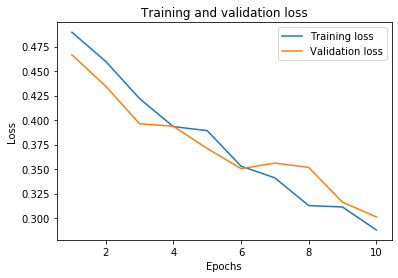

In [94]:
import matplotlib.pyplot as plt #matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

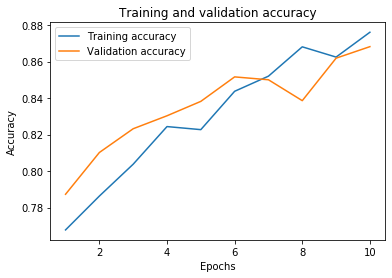

In [95]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [90]:
random_num = np.random.randint(0, 100)
test_data = x[random_num]
test_label = y[random_num]
#clean_test_data = clean_text(test_data)
clean_test_data = test_data
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(clean_test_data)
test_sequences = tokenizer.texts_to_sequences(clean_test_data)
word_index = test_tokenizer.word_index
test_data_padded = pad_sequences(test_sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [91]:
prediction = model.predict(test_data_padded)

In [92]:
prediction[random_num].argsort()[-len(prediction[random_num]):]

array([1, 0])